# A simple neural network autoencoder implemented using TensorFlow  
### Author: Tuan Le
### Email: tuanle@hotmail.de

### Theoretical Insights:  
Suppose we have some data $\mathbf{X}$ (for example an image) which lies in a $M$-dimensional space.  
For example the famous [MNIST Handwritten Digit Dataset](https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners) being greyscale image. In this case one can think of one image a 2-dimensional array (or matrix).  
For the MNIST CASE the dimension would be $28 x 28$. Now assume we `flatten()` this matrix. Think of it when having a straight line of length $K$ and you adjust this line such that you get a square of size $MxM=M^2$.  
This square would be our image matrix. Now we don't want the square again and with the left hand take the beginning of the line and the right hand the end of the line. Try to stretch your arm widely (hopefully you have a wide back). You should have the line of length $K$ again. So what flattening does is the following. 
Suppose we have a matrix $ \begin{pmatrix}
a & b \\ 
c & d
\end{pmatrix} $ and now we flatten this 2D-array such that we get a vector $\begin{pmatrix}
a, &b,  &c,  & d
\end{pmatrix}$  
In this case our $28x28$ matrix will be flatten into a $(781,1)'$ vector. Now the dimension of this flattened vector $\mathbf{x}_i$ is $\mathbb{R}^{781}$ which represents class label (some number), e.g $y_i = 2$. Would it be possible to *reduce* the dimension of this vector ? One might think that if we were to reduce the dimension with some function $g_e()$ we would receive a featuremap $\mathbf{h}_i = g_e(\mathbf{x}_i)$ and from this featuremap $\mathbf{h}_i \in \mathcal{R}^{M_h}$ we could use this as "new feature" in order to learn $y_i$. The first step is called *encodeing*. We map an **observed** pattern (feature-image) into a (hopefully) lower-dimensional space such that we might improve our learning representation.  
Another approach would be, after we have gained the featuremap $\mathbf{h}_i$ we want to transform this vector back into its original form. This is called *decoding*.  
  
So to sum it up we have 2 mechanism within the autoencoder (now we focus on one specific observation $i$):
+ *encoder*: $\mathbf{h}_i = g_e(\mathbf{x}_i)$
+ *decoder*: $\hat{\mathbf{x}}_i \approx g_d(g_e(\mathbf{x}_i)) = g_d(\mathbf{h}_i)$

Note the decoder can be used for *generating* new samples, by applying the decoder function on a sampled vector $h$ which lies in the space $\mathcal{R}^{M_h}$.

So for a neural network encoder following image should show the relationship of encoder and decoder:
 <img src="images/autoencoder_schema.jpg">
([Source: Keras AutoEncoder Blog](https://blog.keras.io/building-autoencoders-in-keras.html)) 
  
What might be interested in is the compressed version $\mathbf{h}_i$.

For the implementation of the neural network autoencoder this implementation will use a simple 1-Hidden-Layer Neural Network represented in the following image (suppose we have 6 input features, hence $M = 6$:
<img src = "images\Autoencoder_simple_nn_6features.png" width="400" height = "400">  
([Source: Stanford Autoencoders Explanation](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/))

So for the connection between the input layer $L_1$ to the first hidden layer $L_2$ we need a (weight) Matrix $\mathbf{V}$ (Note that in this case we reduce the dimension from dimension 6 to 4 (not counting the biases in input and hidden layer)). This weighted sum will be $\mathbf{h}_{in} = \mathbf{Vx}$ and $\mathbf{h} = \sigma(\mathbf{h}_{in})$ where $\sigma$ is the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_functiona).  
After that we need to transform the featuremap $\mathbf{h}$ back to the original space obtaining $\hat{\mathbf{x}}$ via matrix multiplication with $\mathbf{W}$ again, such that $\hat{\mathbf{x}} = \mathbf{Wh} = \mathbf{WVx}$
Training will be done via stochastic gradient descent where the loss function is the euclidean norm, hence:  
$cost(\mathbf{V}, \mathbf{W}) = \sum_{i=1}^{N}\sum_{j=1}^{M}(x_{i,j} - \hat{x}_{i,j})^2$


In [1]:
### Import libraries and modules
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

C:\Users\tuan.le\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Load MNIST data into training and test sets:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Concatenate train and test, since focus in this notebook lies in the autoencoder and not modell-fitting
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
del X_train, y_train, X_test, y_test

print("Shape of training images:", X.shape)
print("One observation can be represented as a vector with:", X.shape[1]*X.shape[2], "entries")

Shape of training images: (70000, 28, 28)
One observation can be represented as a vector with: 784 entries


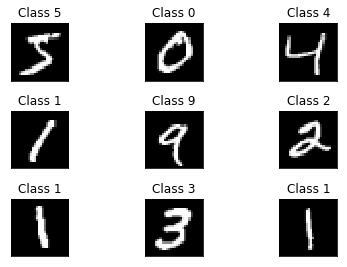

In [3]:
### Show first 9 images of dataset:
# Plot images
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X[i], cmap='gray', interpolation='none')
  plt.title("Class {}".format(y[i]))
  plt.xticks([])
  plt.yticks([])

In [4]:
### Scale X such that training can be done more efficiently:
print("Minimum value in matrix X:", np.min(X))
print("Maximum value in matrix X:", np.max(X))
print("Now scalingi into range (0,1)")
X = X.astype("float32")
X /= np.max(X)
print("Minimum value in matrix X:", np.min(X))
print("Maximum value in matrix X:", np.max(X))

Minimum value in matrix X: 0
Maximum value in matrix X: 255
Now scalingi into range (0,1)
Minimum value in matrix X: 0.0
Maximum value in matrix X: 1.0


Now assume we want to shrink the dimension of the imput vector from 784 to 81. Hence $\mathbf{h_i} \in \mathcal{R}^{81}$ for all $i = 1,2,...,70000$.

In [5]:
#### Train Neural Network Autoencoder ####
# Reset graph
tf.reset_default_graph()
 
# Start graph definition
g = tf.Graph()

# Parameters
image_size = X.shape[1] * X.shape[2]
batch_size = 256
input_layer_size = X.shape[1] * X.shape[2]
hidden_layer_size = 9 * 9 
epochs = 50

## Reshape X into vector format (as flattening)
X = np.reshape(X, newshape=(X.shape[0], X.shape[1]*X.shape[2]))

with g.as_default():
    # Define tensorflow placeholder variables
    #L_1 (in image) [being X]
    inputs = tf.placeholder(tf.float32, (None, image_size), name="inputs")
    #L_3 (in image) [being X_hat]
    targets = tf.placeholder(tf.float32, (None, image_size), name="targets")
    # Output of hidden layer L_2 (in image)
    encoded = tf.layers.dense(inputs, hidden_layer_size, activation = tf.nn.sigmoid)
    # Output layer logits for learning 
    logits = tf.layers.dense(encoded, image_size, activation=None)
    # Sigmoid output from
    decoded = tf.nn.sigmoid(logits, name='output')
    # For optimization we need to learn the weights V and W
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
    # Use euclidean distance loss
    cost = tf.reduce_mean(loss)
    # Use Adam Optimizer for adaptive learning rates/moments
    optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
    init = tf.global_variables_initializer()  
    
## Apply training by running the session with computational tf graph
## Define next_batch function
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [6]:
## Run session on tensorflow graph defined above    
## Create session:
session = tf.Session(graph=g)
# run initializer
session.run(init)    
cnt = 0
for epoch in range(epochs):       
    avg_cost = 0.0   
    n_batches = int(len(X) / batch_size)
    for i in range(n_batches):
        batch_x , batch_y = next_batch(num=batch_size, data=X, labels=y)
        
        cnt+=1
        feed = {inputs: batch_x, targets: batch_x}
        _ , batch_cost = session.run([optimizer, cost], feed_dict = feed)
        # aggregate cost and acc for each batch in epoch
        avg_cost += batch_cost / n_batches
            
    # verbose
    print ("Epoch {:03}: mean squared error = {:.3f}".format(
        epoch+1, avg_cost))
print("Training Complete.")

Epoch 001: mean squared error = 0.294
Epoch 002: mean squared error = 0.248
Epoch 003: mean squared error = 0.218
Epoch 004: mean squared error = 0.193
Epoch 005: mean squared error = 0.175
Epoch 006: mean squared error = 0.162
Epoch 007: mean squared error = 0.151
Epoch 008: mean squared error = 0.142
Epoch 009: mean squared error = 0.135
Epoch 010: mean squared error = 0.128
Epoch 011: mean squared error = 0.123
Epoch 012: mean squared error = 0.119
Epoch 013: mean squared error = 0.116
Epoch 014: mean squared error = 0.112
Epoch 015: mean squared error = 0.109
Epoch 016: mean squared error = 0.107
Epoch 017: mean squared error = 0.105
Epoch 018: mean squared error = 0.104
Epoch 019: mean squared error = 0.102
Epoch 020: mean squared error = 0.101
Epoch 021: mean squared error = 0.099
Epoch 022: mean squared error = 0.098
Epoch 023: mean squared error = 0.097
Epoch 024: mean squared error = 0.096
Epoch 025: mean squared error = 0.095
Epoch 026: mean squared error = 0.094
Epoch 027: m

Plot the results from the neural network autoencoder.  
Note the plot contains 10 images each in 3 rows.  
$i = 1,2,3,4,5,6,7,8,9,10:$  
The first row shows the original images $\mathbf{x}_i$.  
The second row shows the reconstructed image $\hat{\mathbf{x}}_i$.  
The third row shows the compressed image $\hat{\mathbf{h}}_i$.  

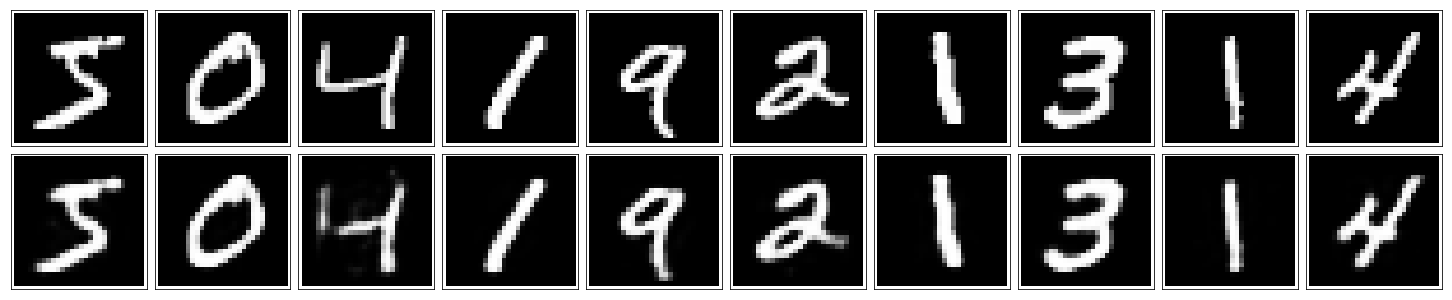

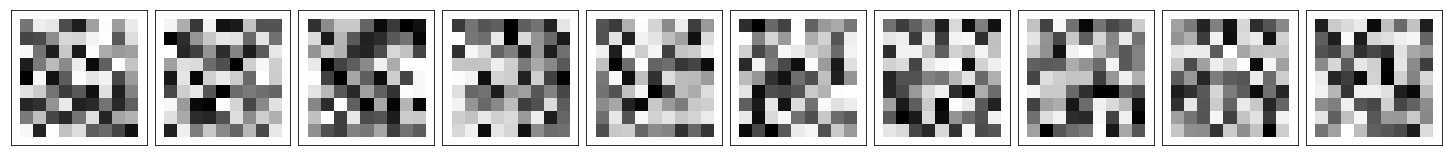

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = X[:10]
reconstructed, compressed = session.run([decoded, encoded], feed_dict={inputs: in_imgs})
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)
# third row: compressed image (in latent space (being vector h))
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,2))
for i, ax in enumerate(fig.axes):
    ax.imshow(compressed[i,:].reshape((9, 9)), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

## Close tensorflow session:
session.close()
## END